In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, XGBRFRegressor

from numpy import sqrt

import warnings
warnings.filterwarnings('ignore')

### Reading and exploring the dataset

In [2]:
df = pd.read_csv('Data_CHF_Zhao_2020_ATE.csv')

In [3]:
df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [4]:
df = df.drop(['id','author'],axis=1)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pressure [MPa],1865.0,10.010949,4.282715,0.1000,6.8900,10.3400,13.7900,20.680
mass_flux [kg/m2-s],1865.0,2862.647721,1656.412247,0.0000,1519.0000,2590.0000,3933.0000,7975.000
x_e_out [-],1865.0,0.016179,0.117575,-0.8667,-0.0483,0.0244,0.1006,0.232
D_e [mm],1865.0,9.417212,6.333807,1.0000,5.6000,8.5000,11.1000,37.500
D_h [mm],1865.0,16.167721,21.182870,1.0000,5.6000,10.3000,15.2000,120.000
length [mm],1865.0,911.340483,726.718974,10.0000,432.0000,625.0000,1778.0000,3048.000
chf_exp [MW/m2],1865.0,3.854638,1.985535,0.8000,2.4000,3.5000,4.8000,19.300


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   geometry             1865 non-null   object 
 1   pressure [MPa]       1865 non-null   float64
 2   mass_flux [kg/m2-s]  1865 non-null   int64  
 3   x_e_out [-]          1865 non-null   float64
 4   D_e [mm]             1865 non-null   float64
 5   D_h [mm]             1865 non-null   float64
 6   length [mm]          1865 non-null   int64  
 7   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 116.7+ KB


In [7]:
df.isna().sum()

geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

In [8]:
df['geometry'].nunique()

3

In [9]:
df['geometry'].value_counts()

tube       1439
annulus     378
plate        48
Name: geometry, dtype: int64

### Visualizing the data (Univariate and Bivariate)

In [10]:
def plot_histogram(df):
    fig,axes = plt.subplots(4,2,figsize=(12,16),dpi=200)
    for ax, col in zip(axes.flatten(), df.columns):
        sns.histplot(df[col],kde=True,element='step',ax=ax)

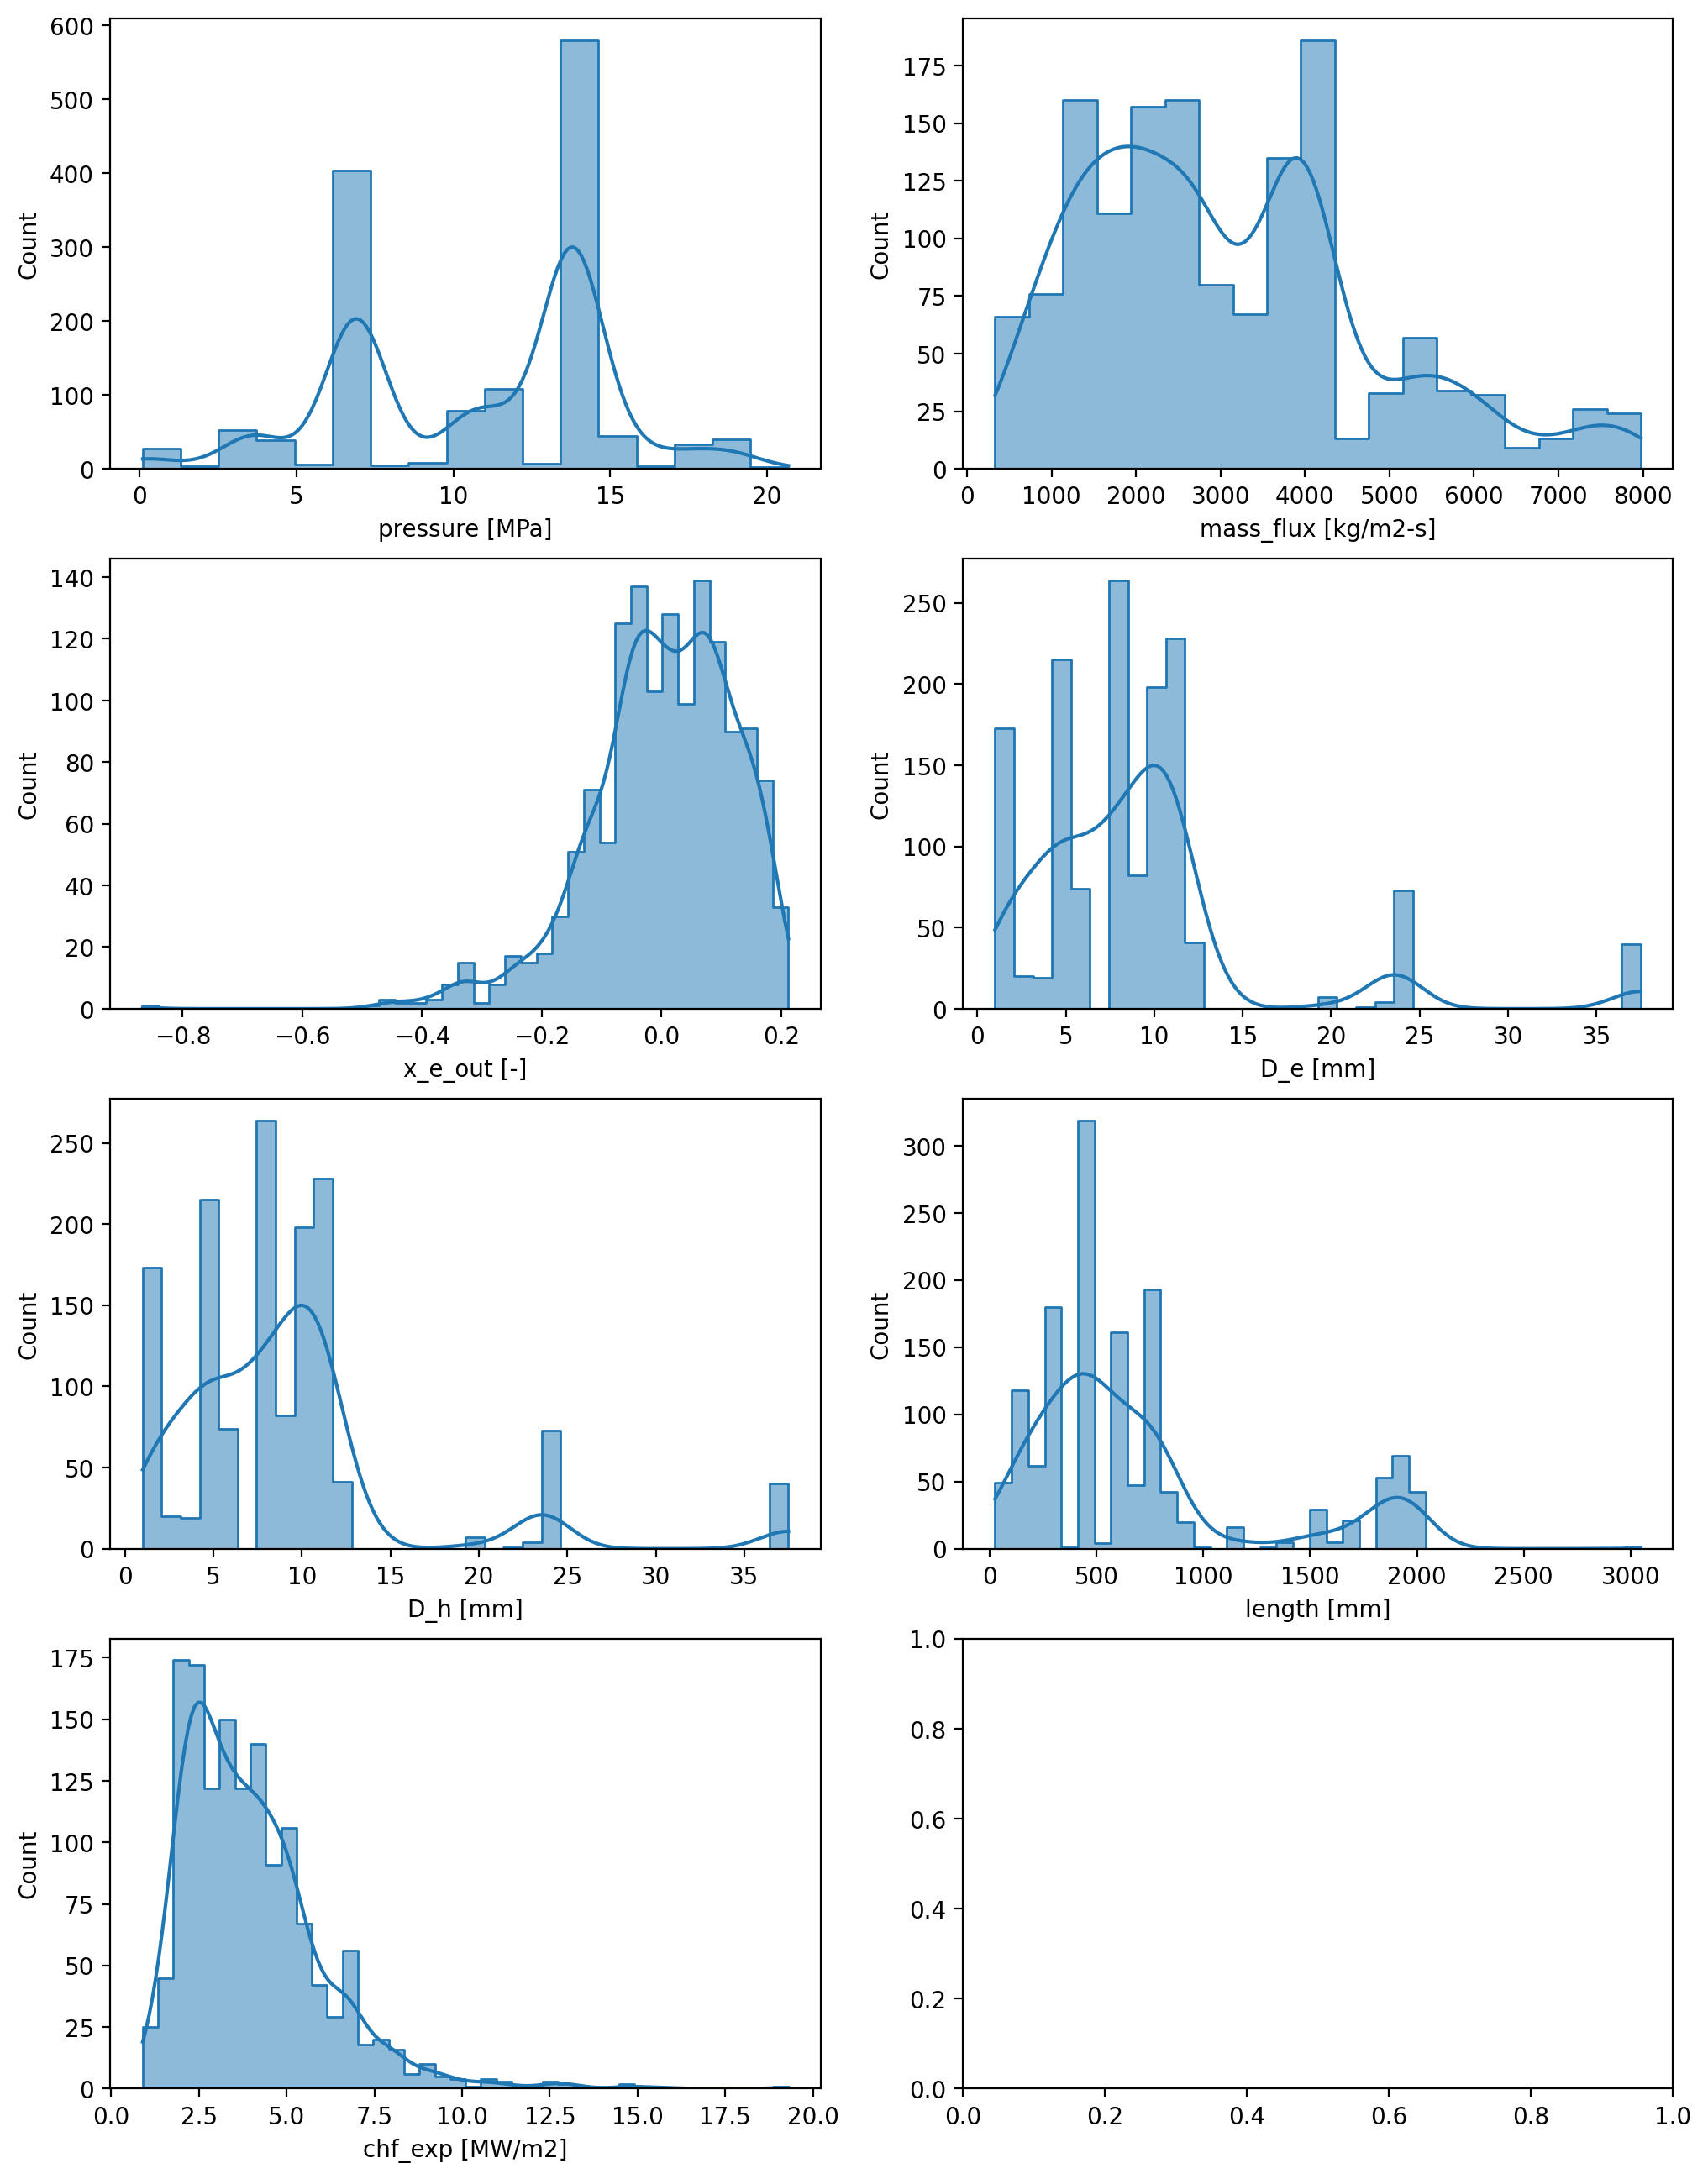

In [11]:
df_tube = df[df['geometry']=='tube'].drop(['geometry'],axis=1)
plot_histogram(df_tube)

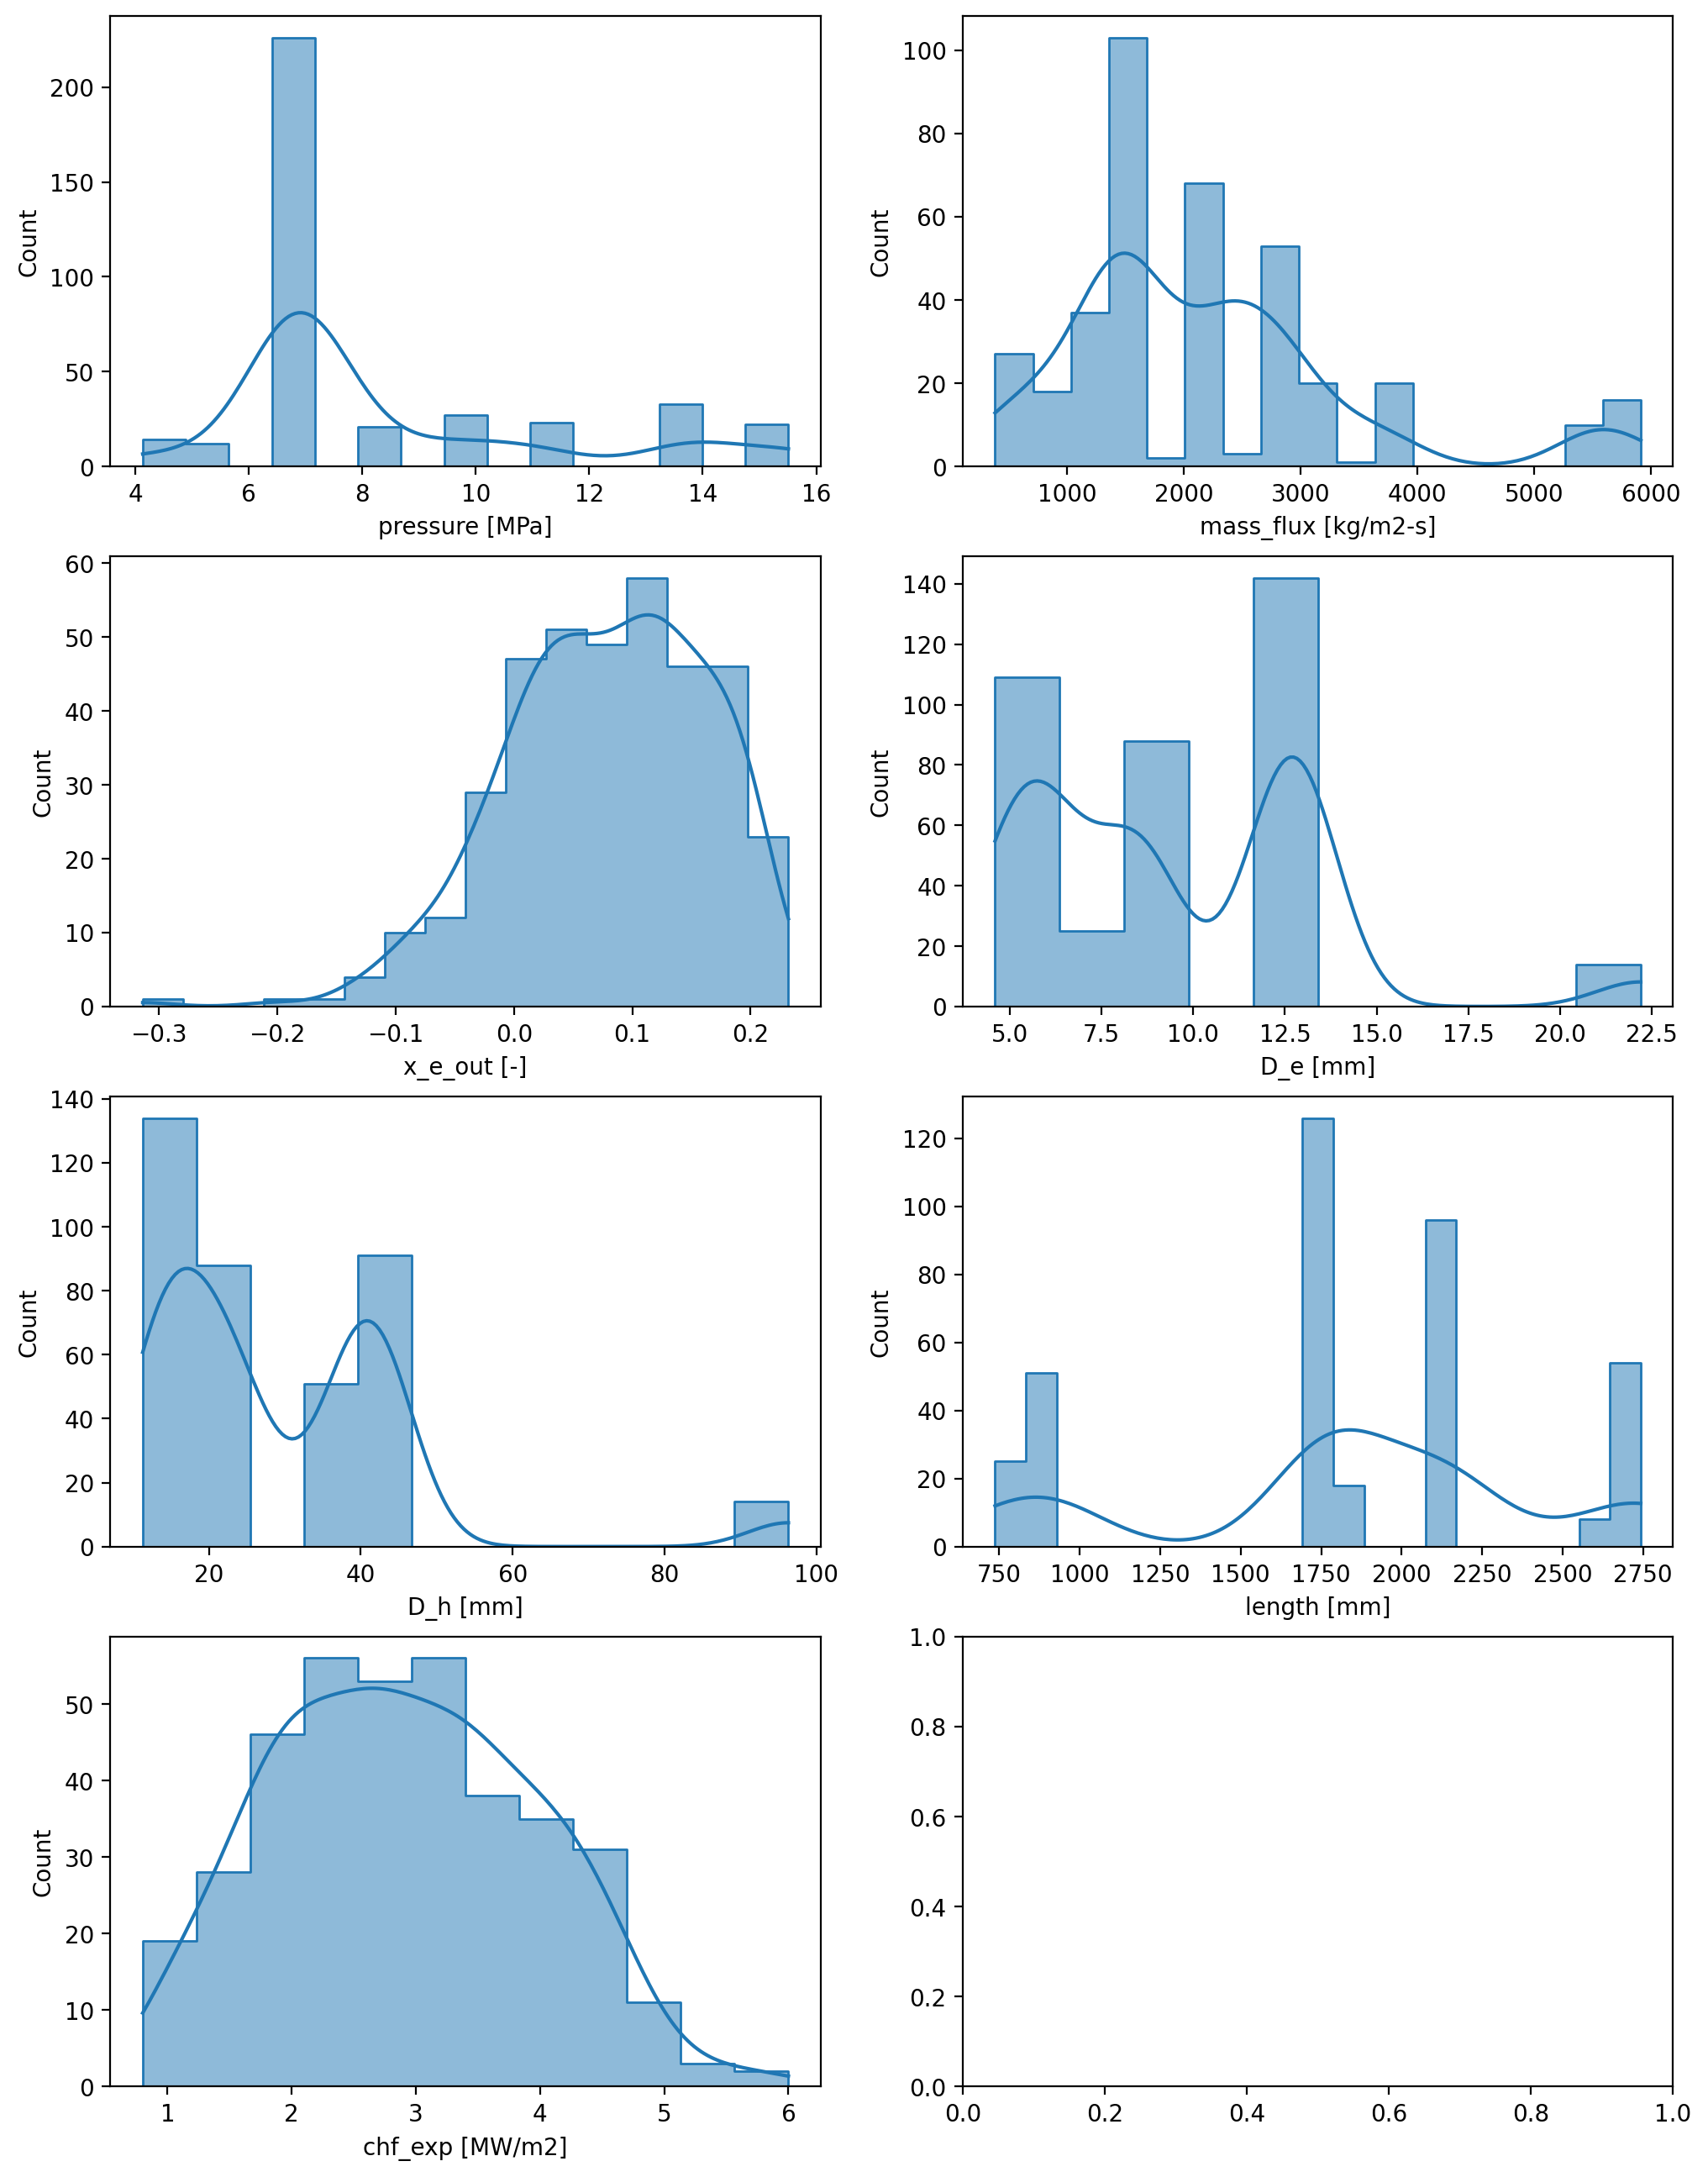

In [12]:
df_annulus = df[df['geometry']=='annulus'].drop(['geometry'],axis=1)
plot_histogram(df_annulus)

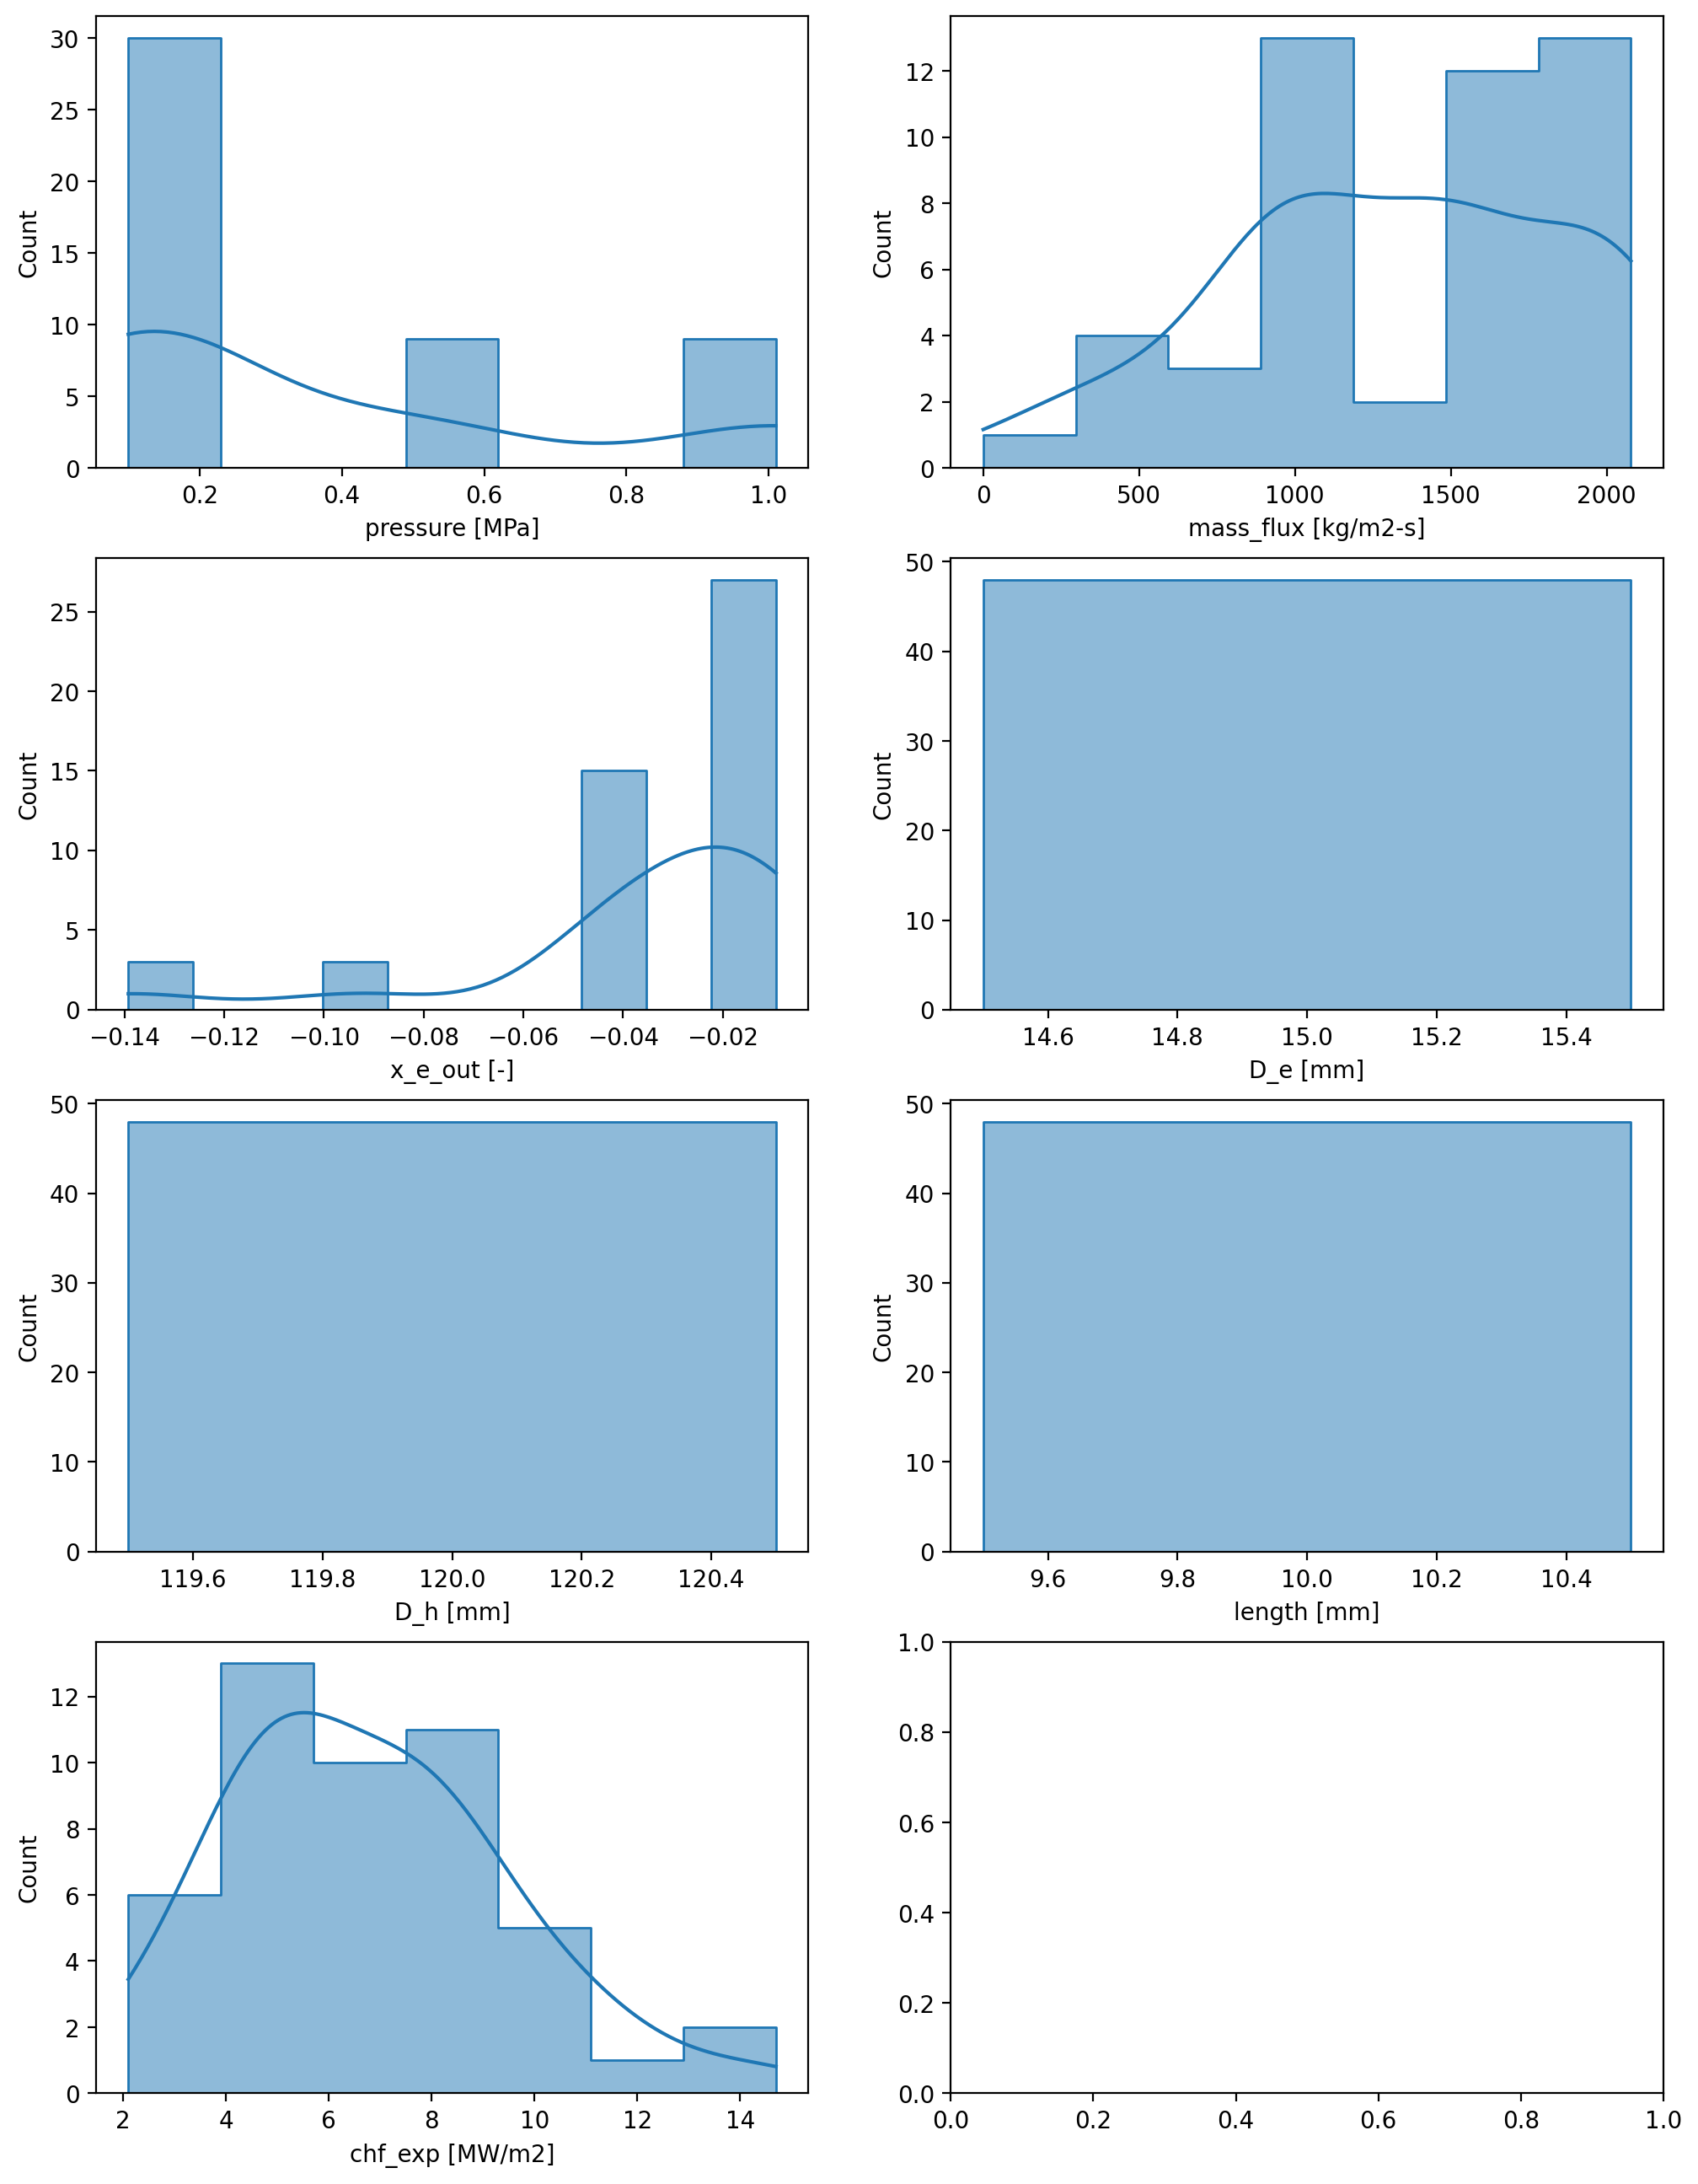

In [13]:
df_plate = df[df['geometry']=='plate'].drop(['geometry'],axis=1)
plot_histogram(df_plate)

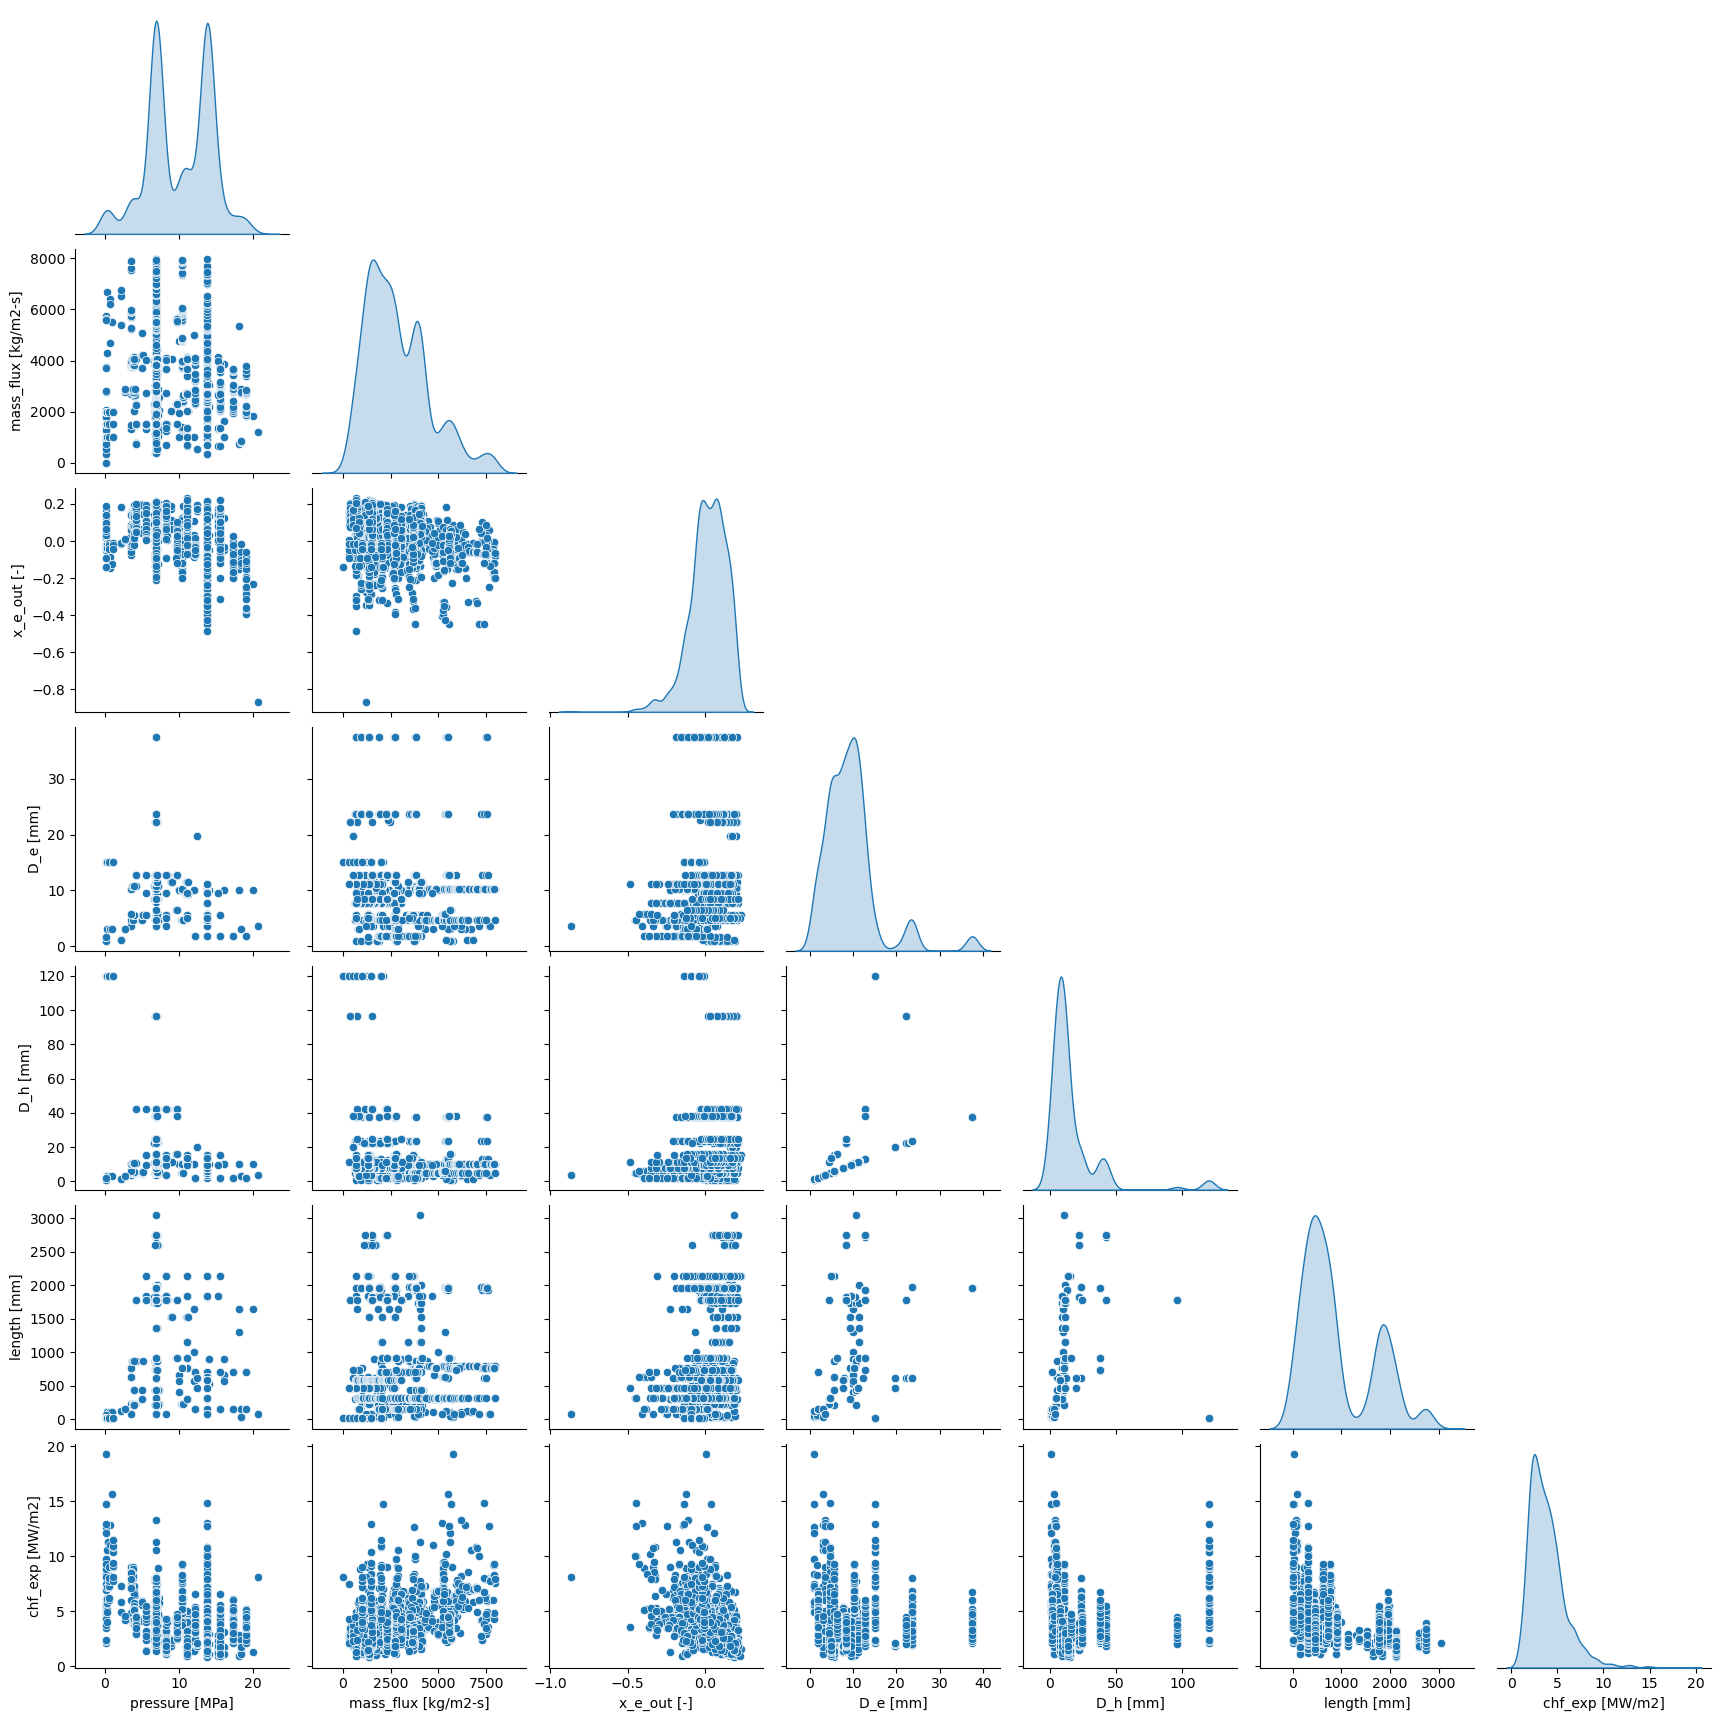

In [14]:
sns.pairplot(df,diag_kind='kde',corner=True)

<Figure size 960x720 with 0 Axes>

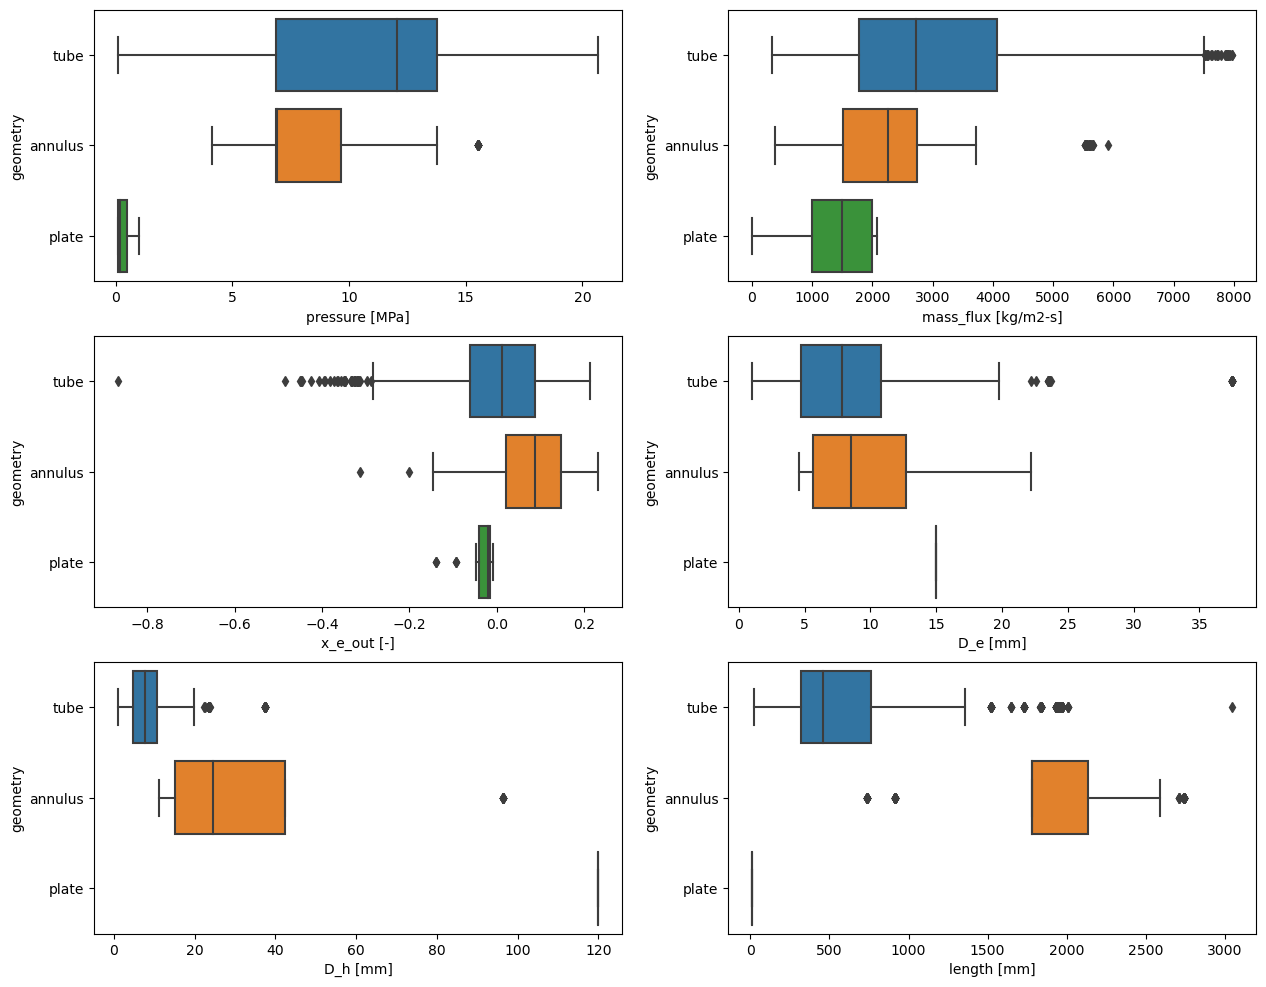

In [15]:
plt.figure(dpi=150)

fig, axes = plt.subplots(3,2,figsize=(15,12))

for ax, col in zip(axes.flatten(), ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
       'D_e [mm]', 'D_h [mm]', 'length [mm]']):
    sns.boxplot(x = df[col], y = df['geometry'], ax=ax)

* There are outliers in the data, specifically corresponding to the tube geometry. 
* These outliers may be experimental artifacts and will be left alone.

In [16]:
df['geometry'].unique()

array(['tube', 'annulus', 'plate'], dtype=object)

In [17]:
df.isna().sum()

geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

In [18]:
df.columns

Index(['geometry', 'pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
       'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]'],
      dtype='object')

## Predicting critical heat flux

### Splitting data into dependent and independent features

In [19]:
df = df.sample(frac=1) #shuffle the data
X = df.drop(['chf_exp [MW/m2]'],axis=1)
y = df['chf_exp [MW/m2]']

### Creating a machine learning pipelines for training different models. 
### Column transformer is used to transform categorical and numerical data.

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=X['geometry'], random_state=1)

In [21]:
X_train.columns

Index(['geometry', 'pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
       'D_e [mm]', 'D_h [mm]', 'length [mm]'],
      dtype='object')

In [22]:
col_transformer = ColumnTransformer([('ohe_geometry',OneHotEncoder(),['geometry'])],remainder=StandardScaler())
#best = SelectKBest(score_func=f_regression,k=9)

In [23]:
model_rf = Pipeline(steps=[('col_transform', col_transformer),
                     #('best',best),
                      ('regressor', RandomForestRegressor(random_state=1))])
model_knn = Pipeline(steps=[('col_transform', col_transformer),
                     #('best',best),
                      ('regressor', KNeighborsRegressor())])
model_xgb = Pipeline(steps=[('col_transform', col_transformer),
                     #('best',best),
                      ('regressor', XGBRegressor())])

In [24]:
model_rf.fit(X_train,y_train)
model_knn.fit(X_train,y_train)
model_xgb.fit(X_train,y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('ohe_geometry',
                                                  OneHotEncoder(),
                                                  ['geometry'])])),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [25]:
# Model performance on train data
train_rf_cv = cross_validate(model_rf,X_train,y_train, scoring='neg_root_mean_squared_error',cv=10, return_estimator=True )
train_knn_cv = cross_validate(model_knn,X_train,y_train, scoring='neg_root_mean_squared_error',cv=10, return_estimator=True )
train_xgb_cv = cross_validate(model_xgb,X_train,y_train, scoring='neg_root_mean_squared_error',cv=10, return_estimator=True )

In [26]:
print('The RMSE for RF Regressor on train data : %.2f'%train_rf_cv['test_score'].mean(),
      'with std. deviation: %.2f'%train_rf_cv['test_score'].std())
print('The RMSE for KNN Regressor on train data: %.2f'%train_knn_cv['test_score'].mean(),
      'with std. deviation: %.2f'%train_knn_cv['test_score'].std())
print('The RMSE for XGB Regressor on train data: %.2f'%train_xgb_cv['test_score'].mean(),
      'with std. deviation: %.2f'%train_xgb_cv['test_score'].std())

The RMSE for RF Regressor on train data : -0.63 with std. deviation: 0.20
The RMSE for KNN Regressor on train data: -0.76 with std. deviation: 0.16
The RMSE for XGB Regressor on train data: -0.61 with std. deviation: 0.22


* The best model is XGB Regressor.

In [27]:
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
print('The RMSE for XGB Regressor on test data: %.3f'%mean_squared_error(y_test,y_pred,squared=False))

The RMSE for XGB Regressor on test data: 0.567


In [28]:
#onehot_columns = model.named_steps['col_transform'].named_transformers_['ohe_geometry'].get_feature_names_out()

#### Hyper-parameter tuning using Randomised CV

In [29]:
parameters = dict(
    regressor__n_estimators= [50,100,200,300],
    regressor__max_depth= range(1, 25),
    regressor__learning_rate=[0.1,0.2,0.3])

random_cv = RandomizedSearchCV(model_xgb,parameters,cv=10,scoring='neg_root_mean_squared_error',random_state=1,verbose=1)

random_cv.fit(X_train,y_train)

print('Train RMSE after tuning: %.3f'%random_cv.best_score_)
print('Best Parameters:\n',random_cv.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Train RMSE after tuning: -0.571
Best Parameters:
 {'regressor__n_estimators': 300, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}


In [30]:
# Best Model
best_model = Pipeline(steps=[('col_transform', col_transformer),
                     #('best',best),
                      ('regressor', XGBRegressor(n_estimators= 300,max_depth=3,learning_rate=0.1,random_state=1))])

best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)

print('Best RMSE for test data: %.3f'%mean_squared_error(y_test,y_pred,squared=False))

Best RMSE for test data: 0.562


### Finding the most important features

In [31]:
X_train = pd.get_dummies(X_train,prefix='geometry')
X_test = pd.get_dummies(X_test,prefix='geometry')

In [32]:
X_train.columns

Index(['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]', 'D_e [mm]',
       'D_h [mm]', 'length [mm]', 'geometry_annulus', 'geometry_plate',
       'geometry_tube'],
      dtype='object')

In [33]:
cols = ['pressure', 'mass_flux', 'x_e_out', 'D_e',
       'D_h', 'length', 'geometry_annulus', 'geometry_plate',
       'geometry_tube']

In [34]:
X_train.set_axis(cols, axis='columns', inplace=True)

In [35]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor()

In [36]:
rfr.feature_importances_

array([0.15207741, 0.25154802, 0.31111379, 0.01723349, 0.02303597,
       0.24107402, 0.00061906, 0.00206472, 0.00123352])

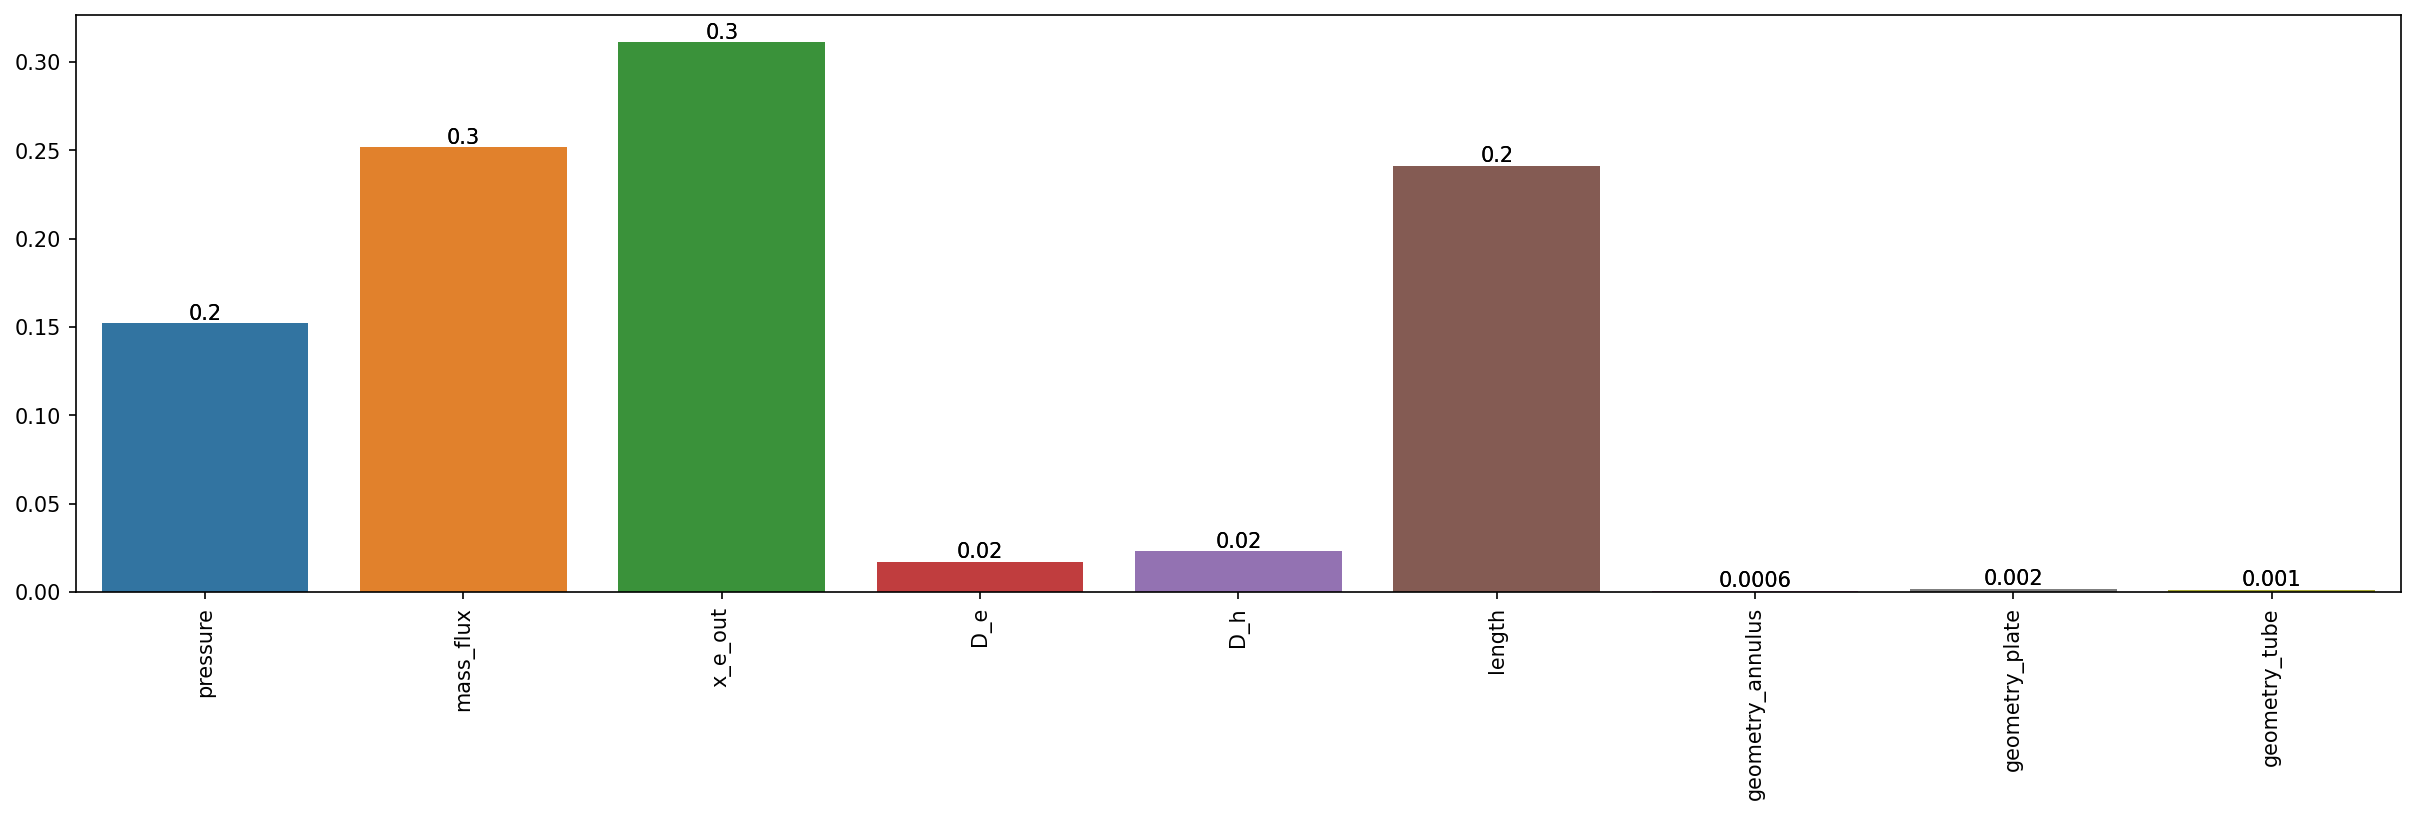

In [37]:
plt.figure(figsize=(20,5),dpi=150)
plt.xticks(rotation=90)
sns.barplot(y=rfr.feature_importances_, x=rfr.feature_names_in_)

x1 = sns.barplot(y=rfr.feature_importances_, x=rfr.feature_names_in_)
for p in x1.containers:
    x1.bar_label(p,fmt='%0.0g')

**The most important features are *pressure, mass_flux, x_e_out and length**

### Training only on the important features

In [38]:
X_train1 = X_train.drop(['geometry_annulus','geometry_plate','geometry_tube','D_e','D_h'], axis=1)
X_test1 = X_test.drop(['geometry_annulus','geometry_plate','geometry_tube','D_e [mm]','D_h [mm]'], axis=1)

[0.16557207 0.23967251 0.33915287 0.25560255]
The RMSE for test data after feature extraction: 0.582
The r2 value after feature extraction          : 0.909


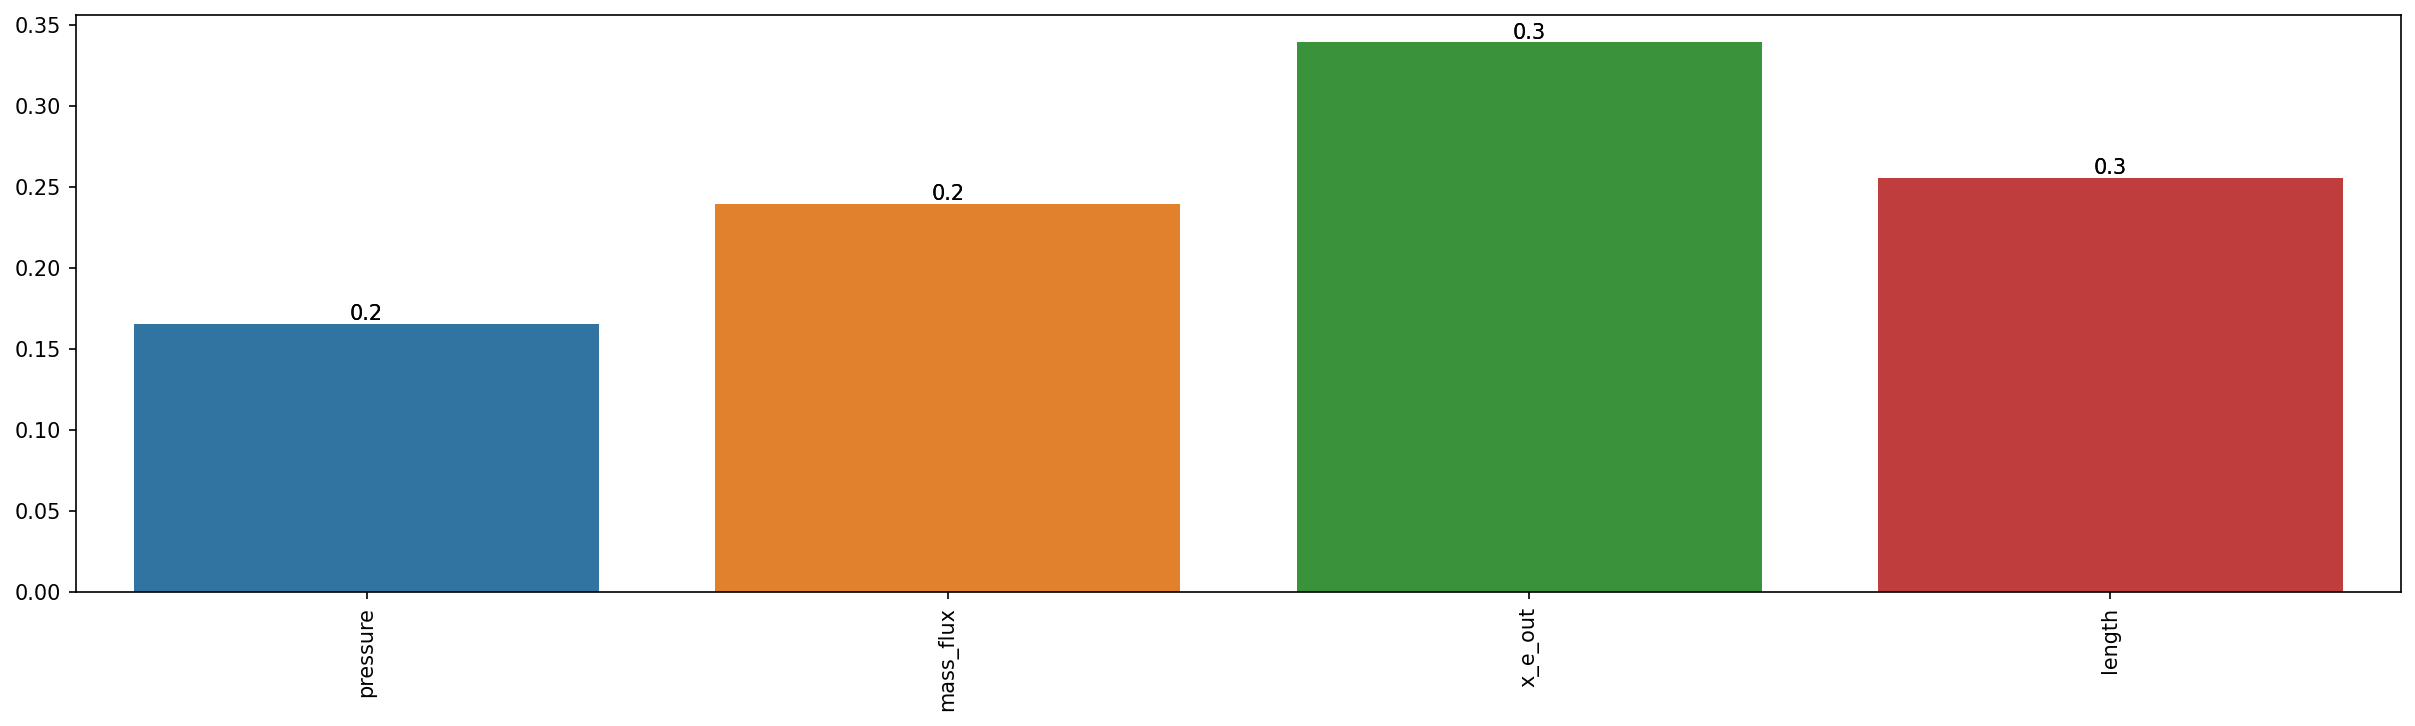

In [40]:
rfr = RandomForestRegressor(random_state=1)
rfr.fit(X_train1,y_train)

print(rfr.feature_importances_)

plt.figure(figsize=(20,5),dpi=150)
plt.xticks(rotation=90)
sns.barplot(y=rfr.feature_importances_, x=rfr.feature_names_in_)

x1 = sns.barplot(y=rfr.feature_importances_, x=rfr.feature_names_in_)
for p in x1.containers:
    x1.bar_label(p,fmt='%0.0g')
    
y_pred = rfr.predict(X_test1)

print('The RMSE for test data after feature extraction: %.3f'%mean_squared_error(y_test,y_pred,squared=False))
print('The r2 value after feature extraction          : %.3f'%r2_score(y_test,y_pred))

#### Even after eliminating features and retaining the most important features, the test RMSE is relatively the same.